<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l -q

     |████████████████████████████████| 82 kB 411 kB/s 
     |████████████████████████████████| 61 kB 9.0 MB/s 
     |████████████████████████████████| 15.7 MB 62.8 MB/s 
     |████████████████████████████████| 11.2 MB 3.8 MB/s 
     |████████████████████████████████| 9.9 MB 70.7 MB/s 
     |████████████████████████████████| 930 kB 62.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [24]:
import math
import os
import random
import torch
from d2l import torch as d2l
import collections
import multiprocessing
from torch import nn

#Resources to go through before running this notebook

The Word2Vec model's objective function involves a slightly mathematical derivation. The original objective is then modified to incorporate a negative sampling based objective which is more computationally efficient during backprop

I would strongly recommend viewing Dr. Manning's amazing Stanford NLP lectures for the same.


[
Stanford CS224N NLP with Deep Learning | Winter 2021 | Lecture 1 - Introduction and Word Vectors
 ](https://www.youtube.com/watch?v=rmVRLeJRkl4&list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ&index=1)

[Stanford CS224N NLP with Deep Learning | Winter 2021 | Lecture 2 - Neural Classifiers
 ](https://www.youtube.com/watch?v=gqaHkPEZAew&list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ&index=2)



#Download data

In [3]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
  """Load the PTB dataset into a list of text lines.""" 
  data_dir = d2l.download_extract('ptb')
  # Read the training set.
  with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
    raw_text = f.read()
  return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [4]:
sentences[:2]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N']]

#Build Vocab

In [5]:
def count_corpus(tokens):
  """Count token frequencies."""
  # Here `tokens` is a 1D list or 2D list
  if len(tokens) == 0 or isinstance(tokens[0], list):
    # Flatten a list of token lists into a 1D list
    tokens = [token for line in tokens for token in line]
  #If its already a 1D list,return  
  return collections.Counter(tokens)
  
class Vocab:
  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None: 
      reserved_tokens = []
    # Sort according to frequencies
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x: x[1],reverse=True)

    #Build vocab on init
    self.idx_to_token=['<unk>']+reserved_tokens #List
    self.token_to_idx={token:idx for idx,token in enumerate(self.idx_to_token)} #Dict

    for token,freq in self._token_freqs:
      #Don't include tokens with freq<min_freq in the vocab
      if freq<min_freq:
        break
      if token not in self.idx_to_token:
        self.idx_to_token.append(token)
        self.token_to_idx[token]=len(self.idx_to_token)-1

  def __len__(self):
    return len(self.idx_to_token)

  @property
  def unk(self):
    # Index for the unknown token
    return 0
  
  @property
  def token_freqs(self):
    # Counter object 
    return self._token_freqs
  
  def __getitem__(self,tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk) 
    #If tokens is a list 
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    #If indices is a list
    return [self.idx_to_token[index] for index in indices]

Further replace words with frequency less than 10 by <unk>

In [6]:
vocab = Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

#Subsample

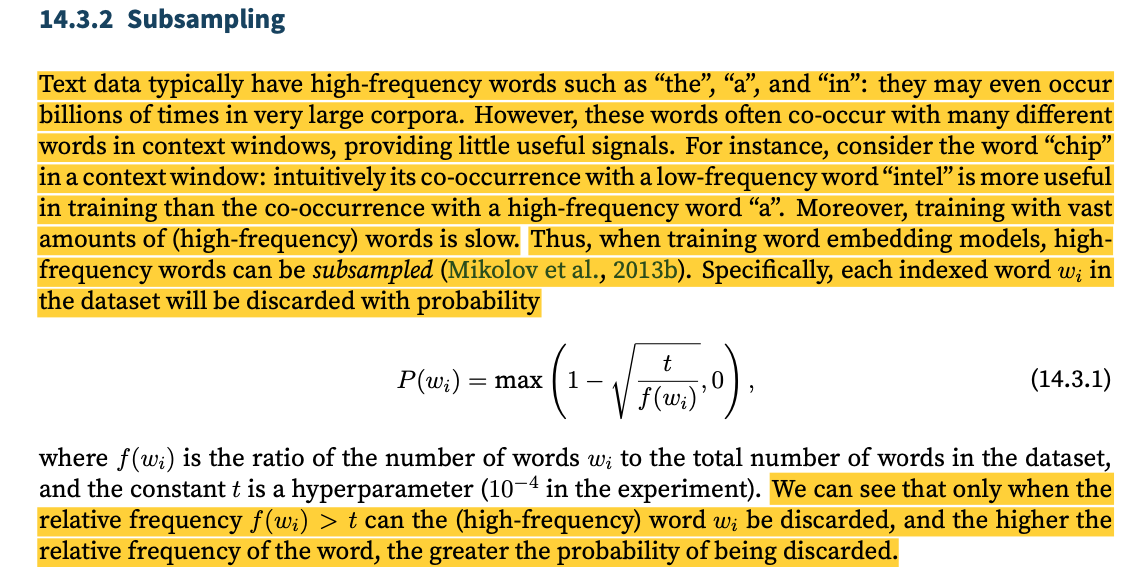

In [7]:
def subsample(sentences, vocab):
  """Subsample high-frequency words."""
  # Exclude unknown tokens '<unk>'
  sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences] 
  counter = count_corpus(sentences)
  num_tokens = sum(counter.values())
  
  # Return True if `token` is kept during subsampling
  def keep(token): 
    return(random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens))

  return ([[token for token in line if keep(token)] for line in sentences], counter)

subsampled, counter = subsample(sentences, vocab)

In [8]:
def compare_counts(token): 
  return (f'# of "{token}": 'f'before={sum([l.count(token) for l in sentences])}, ' f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2092'

In [9]:
compare_counts('join')

'# of "join": before=45, after=45'

In [10]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 2115, 274], [5277, 3054, 1580]]

#Extracting center and context words

The following get_centers_and_contexts function extracts all the center words and their context words from corpus. It uniformly samples an integer between 1 and max_window_size at random as the context window size. For any center word, those words whose distance from it does not exceed the sampled context window size are its context words.


In [11]:
def get_centers_and_contexts(corpus, max_window_size):
  """Return center words and context words in skip-gram."""
  centers, contexts = [], []
  for line in corpus:
    # To form a "center word--context word" pair, each sentence needs to # have at least 2 words
    if len(line) < 2:
      continue
    centers+=line #Every word in the corpus is a center word at some point
    for i in range(len(line)):
      window_size = random.randint(1, max_window_size) #both inclusive
      indices = list(range(max(0, i - window_size),min(len(line), i + 1 + window_size))) # +1 due to the upper limit in the range function
      # Exclude the center word from the context words
      indices.remove(i)
      contexts.append([line[idx] for idx in indices])
  return centers, contexts
    


In [12]:
#TEST
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [1, 3]
center 3 has contexts [2, 4]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [13]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1502653'

In [14]:
all_centers[:3]

[392, 2115, 274]

In [15]:
all_contexts[:3]

[[2115], [392, 274], [392, 2115]]

#Negative Sampling

For example, we can draw 10 random variables X among indices 1, 2, and 3 with sampling prob- abilities P(X = 1) = 2/9,P(X = 2) = 3/9, and P(X = 3) = 4/9 as follows.

**For a pair of center word and context word, we randomly sample K (5 in the experiment) noise words. According to the suggestions in the word2vec paper, the sampling probability P (w) of a noise word w is set to its relative frequency in the dictionary raised to the power of 0.75 (Mikolov et al., 2013b).**

In [16]:
class RandomGenerator:
  """Randomly draw among {1, ..., n} according to n sampling weights.""" 
  def __init__(self, sampling_weights):
    # Exclude
    self.population = list(range(1, len(sampling_weights) + 1)) 
    self.sampling_weights = sampling_weights
    self.candidates = []
    self.i = 0
  
  def draw(self):
    if self.i == len(self.candidates):
      # Cache `k` random sampling results
      #Return a list with k items 
      #The list should contain a randomly selection of the values from a self.population according to self.sampling_weights
      self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
      self.i = 0 
    self.i += 1
    return self.candidates[self.i - 1]

In [17]:
def get_negatives(all_contexts, vocab, counter, K):
  """Return noise words in negative sampling."""
  # Sampling weights for words with indices 1, 2, ... (index 0 is the count of excluded unknown token) in the vocabulary
  sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))] 
  all_negatives, generator = [], RandomGenerator(sampling_weights)

  for contexts in all_contexts: 
    negatives = []
    while len(negatives) < len(contexts) * K: 
      neg = generator.draw()
      # Noise words cannot be context words 
      if neg not in contexts:
        negatives.append(neg) 
    all_negatives.append(negatives)
  return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [18]:
all_contexts[:3]

[[2115], [392, 274], [392, 2115]]

In [19]:
all_negatives[:3]

[[11, 1007, 495, 371, 3928],
 [4608, 4373, 412, 4175, 2837, 541, 42, 3129, 4676, 2477],
 [96, 561, 2491, 116, 3495, 1532, 366, 3522, 1891, 2253]]

#Create the dataset for word2vec

**In a minibatch, the ith example includes a center word and its ni context words and mi noise words. Due to varying context window sizes, ni + mi varies for different i. Thus, for each example we concatenate its context words and noise words in the contexts_negatives variable, and pad zeros until the concatenation length reaches maxi ni + mi (max_len). To exclude paddings in the calculation of the loss, we define a mask variable masks. There is a one-to-one correspondence between elements in masks and elements in contexts_negatives, where zeros (otherwise ones) in masks correspond to paddings in contexts_negatives.**


**To distinguish between positive and negative examples, we separate context words from noise words in contexts_negatives via a labels variable. Similar to masks, there is also a one-to-one cor- respondence between elements in labels and elements in contexts_negatives, where ones (otherwise zeros) in labels correspond to context words (positive examples) in contexts_negatives.**

In [20]:
def batchify(data):
  """Return a minibatch of examples for skip-gram with negative sampling.""" 
  max_len = max(len(c) + len(n) for _, c, n in data)
  centers, contexts_negatives, masks, labels = [], [], [], []
  for center, context, negative in data:
    cur_len = len(context) + len(negative)
    centers += [center]
    contexts_negatives += [context + negative + [0] * (max_len - cur_len)] 
    masks += [[1] * cur_len + [0] * (max_len - cur_len)]
    labels += [[1] * len(context) + [0] * (max_len - len(context))]

  return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [21]:
def load_data_ptb(batch_size, max_window_size, num_noise_words): 
  """Download the PTB dataset and then load it into memory.""" 
  num_workers = multiprocessing.cpu_count()
  sentences = read_ptb()
  vocab = Vocab(sentences, min_freq=10)
  subsampled, counter = subsample(sentences, vocab) 
  corpus = [vocab[line] for line in subsampled] 
  all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size) 
  all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)

  class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
      assert len(centers) == len(contexts) == len(negatives) 
      self.centers = centers
      self.contexts = contexts
      self.negatives = negatives
    
    def __getitem__(self, index):
      return (self.centers[index], self.contexts[index],self.negatives[index]) 
    
    def __len__(self):
      return len(self.centers)

  
  dataset = PTBDataset(all_centers, all_contexts, all_negatives)
  data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, collate_fn=batchify,num_workers=num_workers)
  return data_iter, vocab

In [22]:
data_iter, vocab = load_data_ptb(512, 5, 5) 
names=['centers', 'contexts_negatives', 'masks', 'labels']
for batch in data_iter:
  for name, data in zip(names, batch): 
    print(name, 'shape:', data.shape)
  break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


#The Model

In [23]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u): 
  v = embed_v(center) #batch_size X 1 X embed_dim
  u = embed_u(contexts_and_negatives) #batch_size X max_len X embed_dim
  pred = torch.bmm(v, u.permute(0, 2, 1)) #batch_size X 1 X max_len
  return pred

##About the loss

So here, we would want that all the context words are predicted as 1 whereas the negative sampled words are are predicted as 0.

What the loss does is that for each item (of shape max_len) in pred (of size batch_size,1,max_len) each logit (at position n in batch_size and corresponding to class c) is subjected to the following loss

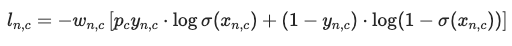



In [36]:
class SigmoidBCELoss(nn.Module):
  # Binary cross-entropy loss with masking 
  def __init__(self):
    super().__init__()
  
  def forward(self, inputs, target, mask=None):
    out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight=mask, reduction="none")
    #batch_size X max_len
    return out.mean(dim=1)

loss = SigmoidBCELoss()

In [41]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]) 
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [45]:
nn.functional.binary_cross_entropy_with_logits(pred, label, weight=mask, reduction="none") #/ mask.sum(axis=1)

tensor([[0.2873, 0.1051, 3.3362, 0.0122],
        [1.3873, 2.3051, 0.0000, 0.0000]])

In [46]:
mask.sum(axis=1)

tensor([4, 2])

In [37]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

In [38]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()): 
  def init_weights(m):
    if type(m) == nn.Embedding: 
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
  # Sum of normalized losses, no. of normalized losses
  metric = d2l.Accumulator(2)
  for epoch in range(num_epochs):
    timer, num_batches = d2l.Timer(), len(data_iter) 
    for batch in data_iter:
      optimizer.zero_grad()
      #center -> batch_size,1 #context_negative-> batch_size, max_len
      #mask-> batch_size, max_len #label->batch_size,max_len
      center, context_negative, mask, label = [data.to(device) for data in batch]
      pred = skip_gram(center, context_negative, net[0], net[1]) #batch_size,1,max_len
      
      #Divide to take the average, multiply to reverse the effect of out.mean(1) 
      #in SigmoidBCELoss above
      #Basically we are taking a mask aware average here
      l = (loss(pred.reshape(label.shape).float(), label.float(), mask) * mask.shape[1] / mask.sum(axis=1))
      #batch_size 

      l.sum().backward()
      optimizer.step()
      metric.add(l.sum(), l.numel())

    print(f'Epoch {epoch+1}: loss {metric[0] / metric[1]:.3f}')

  print(f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

In [39]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

Epoch 1: loss 0.480
Epoch 2: loss 0.454
Epoch 3: loss 0.437
Epoch 4: loss 0.423
Epoch 5: loss 0.410
209782.4 tokens/sec on cuda:0


#Using Word Embeddings

In [54]:
def get_similar_tokens(query_token, k, embed):
  W = embed.weight.data #vocab X embed
  x = W[vocab[query_token]] # embed
  # Compute the cosine similarity. Add 1e-9 for numerical stability 
  #cos-> (vocab,)
  cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *torch.sum(x * x) + 1e-9) 
  topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32') #+1 to avoid input
  for i in topk[1:]: # Remove the input words
    print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.673: computer
cosine sim=0.670: microprocessor
cosine sim=0.637: intel
